In [1]:
import logging
import warnings
from os.path import join

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from arviz import summary
from tqdm.notebook import tqdm

from analysis.bayescorr import runBayesCorr
from analysis.utilities import makeDirIfNeeded
from behavioural_models.models import Glickman1Layer
from plotting.plot_share import lm
from plotting.plot_utils import *

#% Preparations and settings
warnings.filterwarnings("ignore")

logger = logging.getLogger("pymc3")
logger.setLevel(logging.ERROR)

# Random seed
SEED = 2079
np.random.seed(SEED)

# Plot settings
palette = [
    "slategray",
    "darksalmon",
    "mediumaquamarine",
    "indianred",
    "paleturquoise",
    "lightpink",
    "tan",
    "orchid",
]
matplotlib = set_mpl_defaults(matplotlib)

# MCMC settings (passed on to pm.sample)
sample_kwargs = {"cores": 1, "random_seed": SEED, "progressbar": False}

# Directories
DATA_DIR = join("..", "results", "0-clean_data")
RESULTS_DIR = join("..", "results")
OUTPUT_DIR = join("..", "results", "S_supplemental-gda-increased-softmax-beta")
makeDirIfNeeded(OUTPUT_DIR)

In [2]:
# Load trial data
trials = pd.read_csv(join(DATA_DIR, "trials_with-dwells.csv"), index_col=0)

# Load fixation data
fixations = pd.read_csv(join(DATA_DIR, "fixations.csv"), index_col=0)
fixations["duration"] /= 1000

# 0. Processing of behavioural and fixation data, so that they fit the model code
# -------------------------------------------------------------------------------

# For each trial, extract fixated alternatives and fixation durations
# Note that a trial might have missing eyetracking data
# fixations['alternative'] is coded as "A", "B", "C". We need to change this to 0, 1, 2
fixations["alternative"] = pd.Categorical(
    fixations["alternative"], categories=["A", "B", "C"]
).codes
fixations["attribute"] = pd.Categorical(
    fixations["attribute"], categories=["p", "m"]
).codes
# For each trial, make a list of fixated_alternatives and fixation durations
fixated_alternatives = (
    fixations.groupby(["subject", "trial"])["alternative"]
    .apply(lambda x: np.array(x))
    .rename("fixated_alternatives")
    .reset_index()
)
# For each trial, make a list of fixated_alternatives and fixation durations
fixated_attributes = (
    fixations.groupby(["subject", "trial"])["attribute"]
    .apply(lambda x: np.array(x))
    .rename("fixated_attributes")
    .reset_index()
)
fixation_durations = (
    fixations.groupby(["subject", "trial"])["duration"]
    .apply(lambda x: np.array(x))
    .rename("fixation_durations")
    .reset_index()
)
# And merge them into the trial data
trials = trials.merge(fixated_alternatives, on=["subject", "trial"], how="left")
trials = trials.merge(fixated_attributes, on=["subject", "trial"], how="left")
trials = trials.merge(fixation_durations, on=["subject", "trial"], how="left")
# Recode choices into numeric
trials["choice"] = pd.Categorical(trials["choice"], categories=["A", "B", "C"]).codes

In [3]:
# Load estimates and BICs
estimates = pd.read_csv(
    join(RESULTS_DIR, "3-behavioural-modeling", "estimates", "estimates_de1.csv"),
    index_col=0,
).reset_index(drop=True)

In [4]:
n_sims = 50  # number of simulations per trial

# Read GLA estimates
estimates = estimates.loc[estimates["model"] == "glickman1layer"].reset_index(drop=True)
subjects = estimates["subject"].unique()
predictions = []

# increase beta by some factor
beta_multipliers = [1, 1.5, 2, 3]
for beta_multiplier in beta_multipliers:
    print(f"beta_multiplier: {beta_multiplier}")
    for subject in tqdm(subjects):

        # set up model and attach data
        subject_data = trials.loc[trials["subject"] == subject].copy()
        subject_model = Glickman1Layer(data=subject_data)
        subject_model.subject = subject

        # simulate choices
        subject_estimates = [
            estimates.loc[estimates["subject"] == subject, parameter].values[0]
            if parameter != "beta"
            else beta_multiplier
            * estimates.loc[estimates["subject"] == subject, parameter].values[0]
            for parameter in subject_model.parameter_names
        ]

        for rep in range(n_sims):
            predicted_choices = subject_model.simulate_choices(
                parameters=subject_estimates
            )
            predicted_choiceprobs = subject_model.predict_choiceprobs(
                parameters=subject_estimates
            )
            predictions_rep_df = subject_model.data.copy()
            predictions_rep_df["predicted_choice"] = predicted_choices
            for i, option in enumerate(["A", "B", "C"]):
                predictions_rep_df[
                    f"predicted_choiceprob_{option}"
                ] = predicted_choiceprobs[:, i]
            predictions_rep_df["model"] = "glickman1layer"
            predictions_rep_df["rep"] = rep
            for p, parameter in enumerate(subject_model.parameter_names):
                predictions_rep_df[parameter] = subject_estimates[p]
            predictions_rep_df["beta_multiplier"] = beta_multiplier
            predictions.append(
                predictions_rep_df[
                    [
                        "subject",
                        "trial",
                        "effect",
                        "target",
                        "choice",
                        "choice_tcd",
                        "pA",
                        "pB",
                        "pC",
                        "mA",
                        "mB",
                        "mC",
                        "predicted_choice",
                        "predicted_choiceprob_A",
                        "predicted_choiceprob_B",
                        "predicted_choiceprob_C",
                        "rep",
                        "beta_multiplier",
                    ]
                    + subject_model.parameter_names
                ]
            )

predictions = pd.concat(predictions)

## Add `choice_tcd` variable to predicted data
predictions["choice_tcd"] = np.where(
    pd.isnull(predictions["target"]),
    np.nan,
    np.where(
        predictions["predicted_choice"] == 2,
        "decoy",
        np.where(
            ((predictions["predicted_choice"] == 0) & (predictions["target"] == "A"))
            | ((predictions["predicted_choice"] == 1) & (predictions["target"] == "B")),
            "target",
            "competitor",
        ),
    ),
)
predictions.to_csv(join(OUTPUT_DIR, "GLA-predictions_increased-beta.csv"))

beta_multiplier: 1


  0%|          | 0/40 [00:00<?, ?it/s]

beta_multiplier: 1.5


  0%|          | 0/40 [00:00<?, ?it/s]

beta_multiplier: 2


  0%|          | 0/40 [00:00<?, ?it/s]

beta_multiplier: 3


  0%|          | 0/40 [00:00<?, ?it/s]

In [5]:
def lmr_plot(
    x,
    y,
    ax=None,
    lm_kwargs={},
    sample_kwargs={"cores": 1},
    annotation_pos="lower right",
):
    """Make a scatterplot with Bayesian linear regression and Bayesian correlation annotations."""

    if ax is None:
        ax = plt.gca()

    # Linear Model
    ax, lm_trace, lm_summary = lm(
        x=x, y=y, ax=ax, **lm_kwargs, sample_kwargs=sample_kwargs,
    )

    # Correlation
    corr_trace = runBayesCorr(y1=x, y2=y, sample_kwargs=sample_kwargs)
    corr_summary = summary(corr_trace, hdi_prob=0.95)

    # Annotation
    stat_str = (
        f"r = {corr_summary.loc['r', 'mean']:.2f} [{corr_summary.loc['r', 'hdi_2.5%']:.2f}, {corr_summary.loc['r', 'hdi_97.5%']:.2f}]"
        + "\n"
        + f"Intercept = {lm_summary.loc['Intercept', 'mean']:.2f} [{lm_summary.loc['Intercept', 'hdi_2.5%']:.2f}, {lm_summary.loc['Intercept', 'hdi_97.5%']:.2f}]"
        + "\n"
        + f"Slope = {lm_summary.loc['x', 'mean']:.2f} [{lm_summary.loc['x', 'hdi_2.5%']:.2f}, {lm_summary.loc['x', 'hdi_97.5%']:.2f}]"
    )

    if "right" in annotation_pos:
        x = 1
        ma = "right"
        ha = "right"
    elif "left" in annotation_pos:
        x = 0.05
        ma = "left"
        ha = "left"

    if "lower" in annotation_pos:
        y = 0.05
        va = "bottom"
    elif "upper" in annotation_pos:
        y = 1
        va = "top"

    ax.annotate(
        stat_str, [x, y], ma=ma, ha=ha, va=va, fontsize=4, xycoords="axes fraction",
    )

    # Despine
    for side in ["top", "right"]:
        ax.spines[side].set_visible(False)

    return ax

In [6]:
def calc_rst(df, effect="attraction"):
    """Calculate RST.
    
    Parameters
    ----------
    df : pandas.DataFrame
        trial DataFrame, containing columns `subject`, `effect`, `choice_tcd`
    effect : str, one of ['attraction', 'compromise'], optional
        which effect to look at, by default 'attraction'
    
    Returns
    -------
    pandas.Series
        subject-wise RSTs
    """
    cs = (
        df.loc[df["effect"] == effect]
        .groupby("subject")["choice_tcd"]
        .value_counts()
        .rename("frequency")
        .reset_index()
        .pivot_table(index="subject", values="frequency", columns="choice_tcd")
        .fillna(0)
    )
    cs["rst"] = cs["target"] / (cs["target"] + cs["competitor"])
    return cs["rst"]

Beta estimates multiplied by 1...
  Attraction
  Compromise
Beta estimates multiplied by 1.5...
  Attraction


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


  Compromise
Beta estimates multiplied by 2...
  Attraction
  Compromise
Beta estimates multiplied by 3...
  Attraction


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


  Compromise


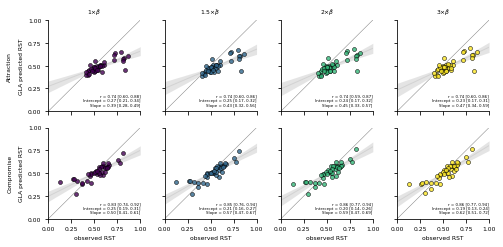

In [10]:
lm_kwargs = dict(xrange=(0, 1), line_color="lightgray")

cmap = plt.cm.get_cmap("viridis")

fig, axs = plt.subplots(
    2,
    len(beta_multipliers),
    figsize=cm2inch(18, 2 * 18 / len(beta_multipliers)),
    sharey="row",
    sharex="col",
)

for i, beta_multiplier in enumerate(beta_multipliers):

    print(f"Beta estimates multiplied by {beta_multiplier}...")

    color = cmap(i / (len(beta_multipliers) - 1))
    lm_kwargs.update(scatter_color=color)

    for e, effect in enumerate(["attraction", "compromise"]):
        print(f"  {effect.capitalize()}")
        ax = axs[e, i]

        # Calculate observed RDT and model predicted RST
        rst_obs = calc_rst(trials, effect=effect)
        rst_pred = calc_rst(
            predictions.loc[predictions["beta_multiplier"] == beta_multiplier],
            effect=effect,
        )

        # Run linear model
        ax = lmr_plot(
            rst_obs, rst_pred, ax=ax, lm_kwargs=lm_kwargs, sample_kwargs=sample_kwargs
        )

        # Annotations
        ## Diagonal for perfect prediction
        ax.plot([0, 1], [0, 1], linewidth=0.5, color="gray", zorder=-1)

        # Y-axis
        ax.set_yticks(np.arange(0, 1.1, 0.25))
        ax.set_ylim(0, 1)

        # X axis
        ax.set_xticks(np.arange(0, 1.1, 0.25))
        ax.set_xlim(0, 1)

        # Labels
        if e == 0:
            ax.set_title(
                f"{beta_multiplier}" + r"$\times \hat{\beta}$"
            )
        if e == 1:
            ax.set_xlabel("observed RST")
        if i == 0:
            ax.set_ylabel(f"{effect.capitalize()}\n\nGLA predicted RST")

# Save figure
plt.tight_layout()
plt.savefig(
    join(OUTPUT_DIR, f"rst_gla-pred-rst_by-beta-multiplier.pdf"), bbox_inches="tight"
)